#CNN clasification with batch train, overfitting checking
*   Download the data
*   Create Dataset using batch size.
*   **Configure the dataset for performance**, using CACHE
*   Standardize the data using keras layer (normalizations)










## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

##Download and explor the data
(3,670 images of flowers)
The dataset contains 5 sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)



228818944/228813984 [==============================] - 1s 0us/step


3670
/root/.keras/datasets/flower_photos


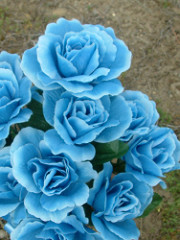

In [4]:
##Count the number of images and see some flowers
image_count = len( list( data_dir.glob('*/*.jpg') ) )
print(image_count)
print(data_dir)
roses = list( data_dir.glob('roses/*') )
PIL.Image.open(str(roses[13]))

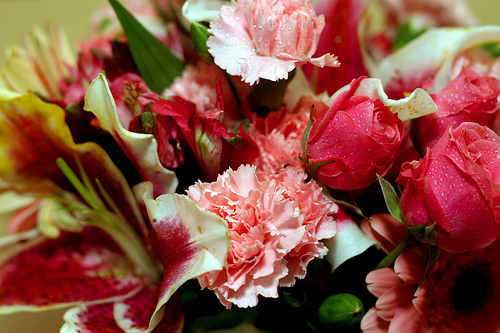

In [ ]:
PIL.Image.open(str(roses[10]))

##Load images from disk and create dataset
using keras.preprocessing.image_dataset_from_directory

In [5]:
## Parameters for the data loader
batch_size = 32
img_height = 180
img_width =  180

In [6]:
##load the data (images) in trainig and validation set with a 0.8:0.2 ratio
# trainig set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir, 
            validation_split=0.2, 
            subset="training", 
            seed=123, 
            image_size = (img_height, img_width), 
            batch_size = batch_size
            )
# validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir, 
            validation_split=0.2, 
            subset="validation", 
            seed=123, 
            image_size = (img_height, img_width), 
            batch_size = batch_size
            )

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [7]:
## class names for the data in these sets are in .class_manes attributes
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


##Visualize some data

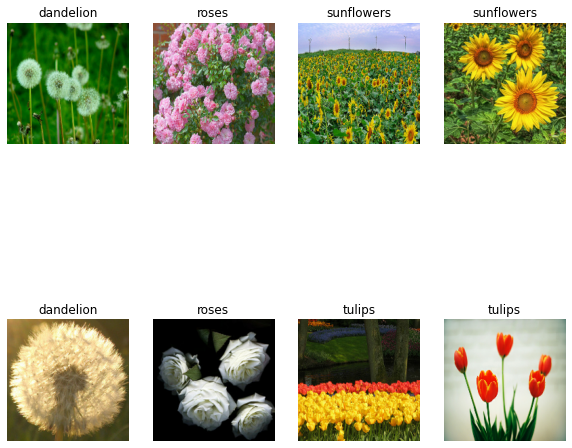

In [10]:
eg_from_images = 8

plt.figure( figsize= (10,10) )
for images, labels in train_ds.take(1):
    for i in range(eg_from_images):
        ax = plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title( class_names[ labels[i] ] )
        plt.axis('off')

In [11]:
## check total number of batches and shape of these batches
count=0
for image_batch, labels_batch in train_ds:
    count+=1
    # print(image_batch.shape)
    # print(labels_batch.shape)
print(count)

92


##Configure the dataset for performance
>use **buffered prefetching** so we can yield data from disk without having I/O become blocking





In [12]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch( buffer_size=AUTOTUNE )
val_ds = val_ds.cache().prefetch( buffer_size=AUTOTUNE )

##Standardize (Normalize) the data

we can do this in two ways, 


1.   in a seperate part of the code
2.   directly add the normalization layer with the model architecture

##If we want to include the resizing logic in our model as well, we can use the **.Resizing** layer.

In [14]:
# in a seperate part of the code
normalization_layer = layers.experimental.preprocessing.Rescaling(1/255)

normalized_ds = train_ds.map( lambda x, y: ( normalization_layer(x), y ) )

image_batch, labels_batch = next( iter(normalized_ds) )
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


## Create CNN model for classification

In [15]:
number_of_classes = len(class_names)

cnn = Sequential( [
                   layers.experimental.preprocessing.Rescaling(1/255, input_shape=( img_height, img_width, 3 ) ),
                   layers.Conv2D( 16, 3, padding='same', activation='relu' ),
                   layers.MaxPool2D(),
                   layers.Conv2D( 32, 3 ,padding='same', activation='relu' ),
                   layers.MaxPool2D(),
                   layers.Conv2D( 64, 3 ,padding='same', activation='relu' ),
                   layers.MaxPool2D(),
                   layers.Flatten(),
                   layers.Dense( 128, activation='relu' ),
                   layers.Dense(number_of_classes)
                ] )

cnn.compile( optimizer='adam',
            loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

##Train the CNN model

In [16]:
epochs = 10
history = cnn.fit(
                train_ds,
                validation_data = val_ds,
                epochs = epochs
                )

Epoch 1/10
92/92 [==============================] - 4s 38ms/step - loss: 1.3699 - accuracy: 0.4390 - val_loss: 1.0694 - val_accuracy: 0.5777
Epoch 2/10
92/92 [==============================] - 2s 20ms/step - loss: 1.0119 - accuracy: 0.6097 - val_loss: 0.9895 - val_accuracy: 0.6117
Epoch 3/10
92/92 [==============================] - 2s 20ms/step - loss: 0.8049 - accuracy: 0.7057 - val_loss: 0.9371 - val_accuracy: 0.6349
Epoch 4/10
92/92 [==============================] - 2s 20ms/step - loss: 0.5813 - accuracy: 0.7878 - val_loss: 0.9558 - val_accuracy: 0.6431
Epoch 5/10
92/92 [==============================] - 2s 20ms/step - loss: 0.3542 - accuracy: 0.8740 - val_loss: 1.0557 - val_accuracy: 0.6362
Epoch 6/10
92/92 [==============================] - 2s 20ms/step - loss: 0.1971 - accuracy: 0.9414 - val_loss: 1.2870 - val_accuracy: 0.6335
Epoch 7/10
92/92 [==============================] - 2s 20ms/step - loss: 0.1013 - accuracy: 0.9717 - val_loss: 1.4485 - val_accuracy: 0.6294
Epoch 8/10
92

##Visualize-- traing, validation accu & loss
from the models traing output

Text(0.5, 1.0, 'Training and Validation loss')

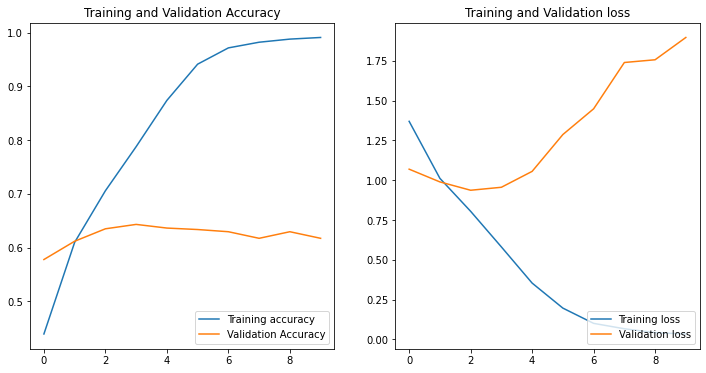

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12,6))

plt.subplot( 1,2,1 )
plt.plot(epochs_range, acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot( 1,2,2 )
plt.plot(epochs_range, loss, label='Training loss')
plt.plot(epochs_range, val_loss, label='Validation loss')
plt.legend(loc='lower right')
plt.title('Training and Validation loss')

#Overfitting

##Data augmentation

In [18]:
data_augmentation = keras.Sequential([
                                    layers.experimental.preprocessing.RandomFlip( "horizontal", 
                                                                                  input_shape=(img_height, img_width,3)
                                                                                ),
                                    layers.experimental.preprocessing.RandomRotation(0.1),
                                    layers.experimental.preprocessing.RandomZoom(0.1),   
                                    layers.experimental.preprocessing.RandomTranslation(height_factor=0.5, width_factor=0.5, seed=123)                                            
                                    ])

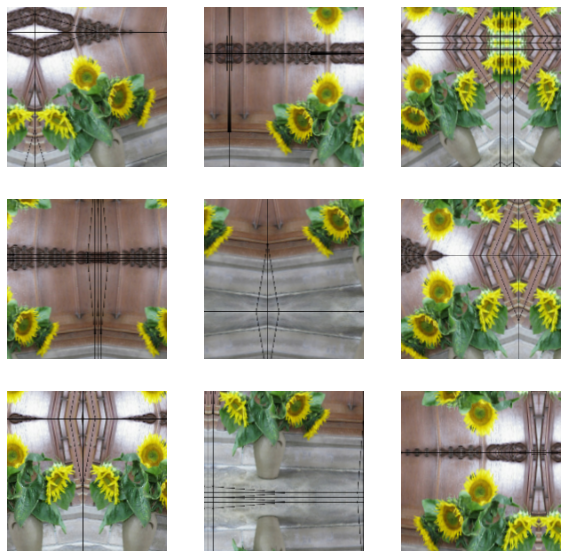

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

##Dropout

In [20]:
cnn2 = Sequential( [
                   data_augmentation, ## data aumentation
                   layers.experimental.preprocessing.Rescaling(1./255, input_shape=( img_height, img_width, 3 ) ),
                   layers.Conv2D( 16, 3, padding='same', activation='relu' ),
                   layers.MaxPool2D(),
                   layers.Conv2D( 32, 3 ,padding='same', activation='relu' ),
                   layers.MaxPool2D(),
                   layers.Conv2D( 64, 3 ,padding='same', activation='relu' ),
                   layers.MaxPool2D(),
                   layers.Dropout(0.2), ## dropout
                   layers.Flatten(),
                   layers.Dense( 128, activation='relu' ),
                   layers.Dense(number_of_classes)
                ] )

cnn2.compile( optimizer='adam',
            loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

cnn2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

Epoch 1/10
92/92 [==============================] - 3s 31ms/step - loss: 1.3432 - accuracy: 0.4247 - val_loss: 1.2517 - val_accuracy: 0.4986
Epoch 2/10
92/92 [==============================] - 3s 29ms/step - loss: 1.1614 - accuracy: 0.5310 - val_loss: 1.0654 - val_accuracy: 0.5913
Epoch 3/10
92/92 [==============================] - 3s 29ms/step - loss: 1.0665 - accuracy: 0.5749 - val_loss: 1.0819 - val_accuracy: 0.5790
Epoch 4/10
92/92 [==============================] - 3s 29ms/step - loss: 1.0338 - accuracy: 0.5838 - val_loss: 0.9697 - val_accuracy: 0.6199
Epoch 5/10
92/92 [==============================] - 3s 29ms/step - loss: 0.9836 - accuracy: 0.6124 - val_loss: 0.9305 - val_accuracy: 0.6362
Epoch 6/10
92/92 [==============================] - 3s 29ms/step - loss: 0.9516 - accuracy: 0.6264 - val_loss: 0.8612 - val_accuracy: 0.6580
Epoch 7/10
92/92 [==============================] - 3s 29ms/step - loss: 0.9110 - accuracy: 0.6383 - val_loss: 0.8713 - val_accuracy: 0.6580
Epoch 8/10
92

Text(0.5, 1.0, 'Training and Validation loss')

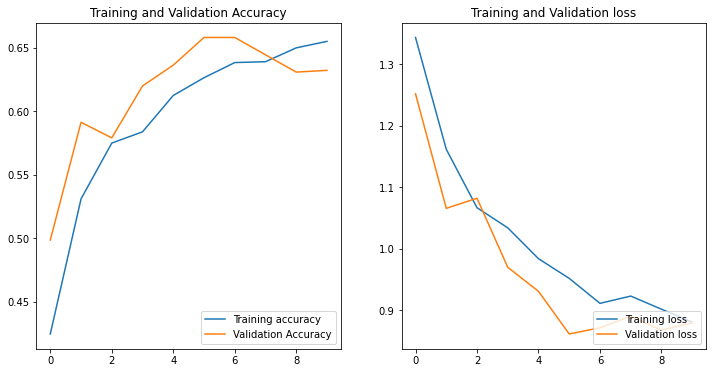

In [21]:
epochs = 10
history = cnn2.fit(
                train_ds,
                validation_data = val_ds,
                epochs = epochs
                )

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12,6))

plt.subplot( 1,2,1 )
plt.plot(epochs_range, acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot( 1,2,2 )
plt.plot(epochs_range, loss, label='Training loss')
plt.plot(epochs_range, val_loss, label='Validation loss')
plt.legend(loc='lower right')
plt.title('Training and Validation loss')

#Predict on new data

> Note: Data augmentation and Dropout layers are inactive at inference time.



In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file( 'Red_sunflower', origin = sunflower_url )

img = keras.preprocessing.image.load_img( sunflower_path, target_size = (img_height, img_width) )

img_array = keras.preprocessing.image.img_to_array(img)
# print(img_array)
img_array = tf.expand_dims(img_array, 0) # Create a batch
# print(img_array)

predictions = cnn.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

predictions = cnn2.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 68.68 percent confidence.
This image most likely belongs to sunflowers with a 69.83 percent confidence.
